### Install and Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import re
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Some files are having .heic extension so we have to convert those to .jpg or .jpeg

In [ ]:
# For HEIC support
try:
    from PIL import Image
    from pillow_heif import register_heif_opener
    register_heif_opener()
    HEIC_SUPPORT = True
    print("✓ HEIC support enabled")
except:
    HEIC_SUPPORT = False
    print("⚠️  HEIC support not available - install with: pip install pillow-heif")

print("✓ All libraries imported successfully!")

### Load and parse image files in a robust manner 
### [should be able to parse diff file types and extensions]

In [ ]:
# ============================================
# CELL 2: Data Loading - CORRECTED INDIVIDUAL IDs
# ============================================

IMAGE_FOLDER = 'images/'

print("="*60)
print("LOADING AND PARSING IMAGE FILES (FIXED)")
print("="*60)

# Find all image files
image_extensions = ['*.jpeg', '*.jpg', '*.JPEG', '*.JPG']
if HEIC_SUPPORT:
    image_extensions.extend(['*.heic', '*.HEIC'])

all_files = []
for ext in image_extensions:
    all_files.extend(Path(IMAGE_FOLDER).glob(ext))

# Remove duplicates
unique_files = {}
for file in all_files:
    base_name = file.stem
    if base_name not in unique_files:
        unique_files[base_name] = file
    else:
        existing_ext = unique_files[base_name].suffix.lower()
        new_ext = file.suffix.lower()
        if new_ext in ['.jpeg', '.jpg'] and existing_ext == '.heic':
            unique_files[base_name] = file

all_files = list(unique_files.values())
print(f"Found {len(all_files)} unique images\n")

# Parse filenames
data = []
unparsed = []

for file in all_files:
    filename = file.stem
    parsed = False
    
    # Pattern 1: HgB_8.9gdl_Individual02_01 (with lighting variation)
    match = re.match(r'HgB[_\s]*(\d+\.?\d*)gdl[_\s]*In[dv]ividual(\d{2})[_\s]*(\d+)', filename, re.IGNORECASE)
    if match:
        hgb_value = float(match.group(1))
        individual_num = match.group(2)
        lighting = int(match.group(3))
        
        # CRITICAL FIX: Individual ID = HgB + Individual Number
        individual_id = f"IND_{individual_num}_HgB{hgb_value}"
        
        data.append({
            'filename': str(file),
            'hgb': hgb_value,
            'individual_id': individual_id,
            'lighting_variant': lighting,
            'ethnicity': 'Unknown',
            'file_type': file.suffix.lower()
        })
        parsed = True
    
    # Pattern 2: HgB_10.7gdl_Individual01 (without lighting number)
    if not parsed:
        match = re.match(r'HgB[_\s]*(\d+\.?\d*)gdl[_\s]*In[dv]ividual(\d{2})$', filename, re.IGNORECASE)
        if match:
            hgb_value = float(match.group(1))
            individual_num = match.group(2)
            
            # CRITICAL FIX: Each is a SEPARATE individual
            individual_id = f"IND_{individual_num}_HgB{hgb_value}"
            
            data.append({
                'filename': str(file),
                'hgb': hgb_value,
                'individual_id': individual_id,
                'lighting_variant': 1,
                'ethnicity': 'Unknown',
                'file_type': file.suffix.lower()
            })
            parsed = True
    
    # Pattern 3: Random samples
    if not parsed:
        match = re.match(r'Random[_\s]*(?:HgB[_\s]*)?(\d+\.?\d*)gdl[_\s]*(.+)?', filename, re.IGNORECASE)
        if match:
            ethnicity = match.group(2).strip() if match.group(2) else 'Unknown'
            individual_id = f"RAND_{ethnicity}_{match.group(1)}"
            
            data.append({
                'filename': str(file),
                'hgb': float(match.group(1)),
                'individual_id': individual_id,
                'lighting_variant': 1,
                'ethnicity': ethnicity,
                'file_type': file.suffix.lower()
            })
            parsed = True
    
    if not parsed:
        unparsed.append(filename)

df = pd.DataFrame(data)

print(f"✓ Successfully parsed: {len(df)} images")
if unparsed:
    print(f"✗ Unparsed: {len(unparsed)} files")

print(f"\n{'='*60}")
print("DATASET SUMMARY")
print('='*60)
print(f"Total images: {len(df)}")
print(f"Unique individuals: {df['individual_id'].nunique()}")
print(f"HgB range: {df['hgb'].min():.1f} - {df['hgb'].max():.1f} g/dL")

print(f"\nIndividual breakdown:")
ind_counts = df.groupby('individual_id').size().sort_values(ascending=False)
for ind_id, count in ind_counts.items():
    hgb = df[df['individual_id'] == ind_id]['hgb'].iloc[0]
    print(f"  {ind_id}: {count} images, HgB={hgb:.1f} g/dL")

# VERIFY no mixed HgB values
print("\n" + "="*60)
print("VERIFYING DATA QUALITY")
print("="*60)
errors = 0
for ind_id in df['individual_id'].unique():
    hgb_values = df[df['individual_id'] == ind_id]['hgb'].unique()
    if len(hgb_values) > 1:
        print(f"⚠️  {ind_id} has inconsistent HgB: {hgb_values}")
        errors += 1

if errors == 0:
    print("✓ All individuals have consistent HgB values!")
else:
    print(f"\n⚠️  Found {errors} individuals with data quality issues!")

df.head(15)

### Visualize Data Distribution

### Plot the HgB distribution (normal range 12-17 g/dL women, 13.5-18 men)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: HgB distribution
axes[0, 0].hist(df['hgb'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['hgb'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["hgb"].mean():.2f}')
axes[0, 0].set_xlabel('Hemoglobin (g/dL)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Distribution of Hemoglobin Levels', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Images per individual
ind_counts = df.groupby('individual_id').size().sort_values(ascending=False)
axes[0, 1].barh(range(len(ind_counts)), ind_counts.values, color='coral')
axes[0, 1].set_yticks(range(len(ind_counts)))
axes[0, 1].set_yticklabels(ind_counts.index, fontsize=8)
axes[0, 1].set_xlabel('Number of Images', fontsize=11)
axes[0, 1].set_title('Images per Individual', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: HgB by ethnicity
ethnicity_hgb = df.groupby('ethnicity')['hgb'].agg(['mean', 'std', 'count'])
axes[1, 0].bar(range(len(ethnicity_hgb)), ethnicity_hgb['mean'], 
               yerr=ethnicity_hgb['std'], capsize=5, alpha=0.7, color='lightgreen')
axes[1, 0].set_xticks(range(len(ethnicity_hgb)))
axes[1, 0].set_xticklabels(ethnicity_hgb.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Mean HgB (g/dL)', fontsize=11)
axes[1, 0].set_title('Mean HgB by Ethnicity', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: File type distribution
file_counts = df['file_type'].value_counts()
axes[1, 1].pie(file_counts.values, labels=file_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('File Type Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Displays sample images at the different HgB levels

In [ ]:
print("Sample lip images from dataset:")

# Select diverse samples (up to 6)
sample_size = min(6, len(df))
sample_rows = df.sample(sample_size, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_rows.iterrows()):
    if i >= 6:
        break
    
    # Load image based on file type
    if row['file_type'] in ['.heic']:
        if HEIC_SUPPORT:
            img_pil = Image.open(row['filename']).convert('RGB')
            img_rgb = np.array(img_pil)
        else:
            axes[i].text(0.5, 0.5, 'HEIC not supported', ha='center', va='center')
            axes[i].axis('off')
            continue
    else:
        img = cv2.imread(row['filename'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"{row['individual_id']}\nHgB: {row['hgb']} g/dL", fontsize=10)
    axes[i].axis('off')

# Hide unused subplots
for i in range(sample_size, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Image Preprocessing Functions

In [ ]:
def preprocess_image_for_hgb(image_path, file_type):
    """
    Preprocess lip images to be robust to lighting and device variations
    Uses CLAHE for lighting normalization
    """
    # Load image
    if file_type in ['.heic'] and HEIC_SUPPORT:
        img_pil = Image.open(image_path).convert('RGB')
        img_rgb = np.array(img_pil)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = cv2.imread(image_path)
    
    # Convert to LAB color space (better for skin tones)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to L channel
    # This normalizes lighting variations
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_normalized = clahe.apply(l)
    
    # Merge back
    lab_normalized = cv2.merge([l_normalized, a, b])
    img_normalized = cv2.cvtColor(lab_normalized, cv2.COLOR_LAB2BGR)
    
    return img_normalized

print("✓ Image preprocessing function ready!")
print("✓ Uses CLAHE for lighting normalization")

### Define feature extraction function

RGB – Red, Green, Blue order (standard for images).

BGR – Same as RGB but channel order flipped (OpenCV default).

HSV – Hue, Saturation, Value (human-friendly, great for color filtering).

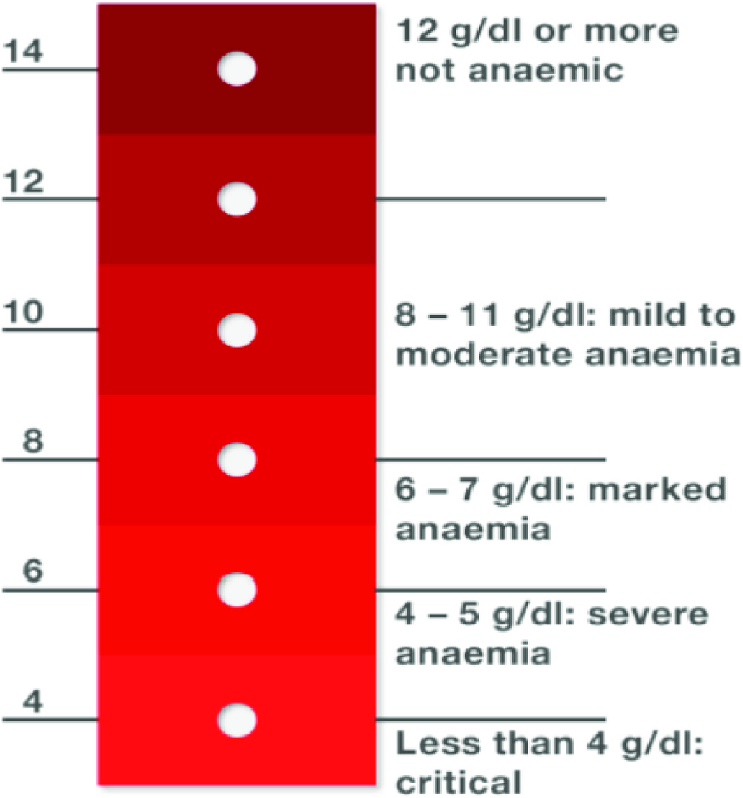

In [ ]:
def extract_advanced_features(image_path, file_type):
    """
    Extract comprehensive color features from lip images
    Focus on features known to correlate with hemoglobin
    """
    
    # Load and preprocess image
    img_normalized = preprocess_image_for_hgb(image_path, file_type)
    img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
    
    features = {}
    
    # === Focus on Red Channel (most correlated with hemoglobin) ===
    r_channel = img_rgb[:, :, 0]
    g_channel = img_rgb[:, :, 1]
    b_channel = img_rgb[:, :, 2]
    
    # Basic statistics
    features['R_mean'] = r_channel.mean()
    features['R_median'] = np.median(r_channel)
    features['R_std'] = r_channel.std()
    features['R_min'] = r_channel.min()
    features['R_max'] = r_channel.max()
    features['R_range'] = features['R_max'] - features['R_min']
    
    features['G_mean'] = g_channel.mean()
    features['G_median'] = np.median(g_channel)
    features['G_std'] = g_channel.std()
    
    features['B_mean'] = b_channel.mean()
    features['B_median'] = np.median(b_channel)
    features['B_std'] = b_channel.std()
    
    # Percentiles (robust to outliers)
    for p in [10, 25, 50, 75, 90]:
        features[f'R_p{p}'] = np.percentile(r_channel, p)
    
    # === Critical Ratios for Hemoglobin Detection ===
    eps = 1e-6
    features['RG_ratio'] = features['R_mean'] / (features['G_mean'] + eps)
    features['RB_ratio'] = features['R_mean'] / (features['B_mean'] + eps)
    features['GB_ratio'] = features['G_mean'] / (features['B_mean'] + eps)
    
    # Normalized ratios
    total_intensity = features['R_mean'] + features['G_mean'] + features['B_mean']
    features['R_normalized'] = features['R_mean'] / (total_intensity + eps)
    features['G_normalized'] = features['G_mean'] / (total_intensity + eps)
    features['B_normalized'] = features['B_mean'] / (total_intensity + eps)
    
    # === LAB Color Space (perceptually uniform) ===
    lab = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2LAB)
    features['L_mean'] = lab[:, :, 0].mean()  # Lightness
    features['A_mean'] = lab[:, :, 1].mean()  # Red-Green axis (IMPORTANT!)
    features['B_mean_lab'] = lab[:, :, 2].mean()  # Blue-Yellow axis
    
    features['L_std'] = lab[:, :, 0].std()
    features['A_std'] = lab[:, :, 1].std()
    
    # A channel percentiles (redness)
    for p in [25, 50, 75]:
        features[f'A_p{p}'] = np.percentile(lab[:, :, 1], p)
    
    # === HSV Color Space ===
    hsv = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2HSV)
    features['H_mean'] = hsv[:, :, 0].mean()
    features['H_median'] = np.median(hsv[:, :, 0])
    features['S_mean'] = hsv[:, :, 1].mean()
    features['S_median'] = np.median(hsv[:, :, 1])
    features['V_mean'] = hsv[:, :, 2].mean()
    
    # === YCrCb (Skin tone detection) ===
    ycrcb = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2YCrCb)
    features['Cr_mean'] = ycrcb[:, :, 1].mean()  # Red-difference
    features['Cr_std'] = ycrcb[:, :, 1].std()
    features['Cb_mean'] = ycrcb[:, :, 2].mean()  # Blue-difference
    
    # === Derived Medical Features ===
    features['pallor_index'] = features['A_mean']  # LAB 'a' channel
    features['redness'] = features['R_mean'] - (features['G_mean'] + features['B_mean']) / 2
    features['saturation_overall'] = features['S_mean']
    features['chroma_rg'] = features['R_mean'] - features['G_mean']
    features['chroma_rb'] = features['R_mean'] - features['B_mean']
    
    return features

print("✓ Enhanced feature extraction function ready!")
print(f"✓ Extracts {len(extract_advanced_features(df.iloc[0]['filename'], df.iloc[0]['file_type']))} features per image")

### Extract Featrures from all images

### Display all the extracted features in a nice table format

In [ ]:
print("Extracting features from all images...")
print("="*60)

features_list = []
failed_images = []

for idx, row in df.iterrows():
    try:
        features = extract_advanced_features(row['filename'], row['file_type'])
        features_list.append(features)
        
        if (idx + 1) % 5 == 0:
            print(f"  Processed {idx + 1}/{len(df)} images...")
    except Exception as e:
        print(f"  ✗ Failed to process {row['filename']}: {str(e)}")
        failed_images.append(idx)

# Remove failed images from df
if failed_images:
    df = df.drop(failed_images).reset_index(drop=True)
    print(f"\n⚠️  Removed {len(failed_images)} failed images")

features_df = pd.DataFrame(features_list)

print(f"\n✓ Successfully extracted features from {len(features_df)} images")
print(f"✓ Total features per image: {len(features_df.columns)}")

print("\nFeature statistics (sample):")
features_df.iloc[:, :10].describe()

### Prepare data for modeling

In [ ]:
# Prepare feature matrix
X = features_df.values
y = df['hgb'].values
groups = df['individual_id'].values

# Standardize features (important for some models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of unique individuals: {len(np.unique(groups))}")
print(f"\nFeatures are standardized (mean=0, std=1)")
print("✓ Data ready for modeling!")

### Train model with Cross-Validation

### Train the models using the Random Forest Model using proper cross-validation

In [ ]:
print("="*60)
print("TRAINING OPTIMIZED MODELS FOR SMALL DATASET")
print("="*60)
print("Using Leave-One-Individual-Out Cross-Validation\n")

# Models optimized for small datasets (31 images, 12 individuals)
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.8,
        min_samples_split=3,
        min_samples_leaf=2,
        random_state=42
    ),
    'Extra Trees': RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=False,
        random_state=42
    ),
    'Ridge Regression': Ridge(alpha=10.0),
    'SVR': SVR(kernel='rbf', C=5, gamma='scale', epsilon=0.2)
}

# Store results
results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)
    
    logo = LeaveOneGroupOut()
    predictions = []
    actuals = []
    individual_errors = []
    
    fold = 1
    for train_idx, test_idx in logo.split(X_scaled, y, groups):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Clip predictions to reasonable HgB range (4-18 g/dL)
        y_pred = np.clip(y_pred, 4.0, 18.0)
        
        # Store results
        predictions.extend(y_pred)
        actuals.extend(y_test)
        
        # Calculate error for this fold
        mae = mean_absolute_error(y_test, y_pred)
        individual_errors.append(mae)
        
        test_individual = groups[test_idx][0]
        print(f"  Fold {fold:2d} ({test_individual}): MAE = {mae:.3f} g/dL")
        fold += 1
    
    # Calculate metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(np.array(predictions) - np.array(actuals))
    
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'Mean Bias': mean_bias,
        'Predictions': predictions,
        'Actuals': actuals,
        'Individual Errors': individual_errors
    }
    
    print(f"\n  Overall MAE: {mae:.3f} g/dL")
    print(f"  RMSE: {rmse:.3f} g/dL")

### Weighted Ensemble Based on Individual Performance

In [ ]:
print("\n" + "="*60)
print("TRAINING WEIGHTED ENSEMBLE MODEL")
print("="*60)

# Select best 3 models for ensemble
ensemble_models = {
    'GBM': GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, random_state=42),
    'RF': RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_split=3, max_features='sqrt', random_state=42),
    'Ridge': Ridge(alpha=10.0)
}

logo = LeaveOneGroupOut()
ensemble_predictions = []
ensemble_actuals = []
ensemble_individual_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train all models and collect predictions
    model_preds = []
    model_errors = []
    
    for model_name, model in ensemble_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = np.clip(pred, 4.0, 18.0)
        
        model_preds.append(pred)
        # Calculate validation error on training set for weighting
        val_pred = model.predict(X_train)
        val_error = mean_absolute_error(y_train, val_pred)
        model_errors.append(val_error)
    
    # Weight models inversely proportional to their errors
    weights = 1.0 / (np.array(model_errors) + 1e-6)
    weights = weights / weights.sum()
    
    # Weighted average
    ensemble_pred = np.average(model_preds, axis=0, weights=weights)
    
    ensemble_predictions.extend(ensemble_pred)
    ensemble_actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_individual_errors.append(mae)

# Calculate metrics
ensemble_mae = mean_absolute_error(ensemble_actuals, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actuals, ensemble_predictions))
ensemble_bias = np.mean(np.array(ensemble_predictions) - np.array(ensemble_actuals))

print(f"\n🎯 WEIGHTED ENSEMBLE RESULTS:")
print(f"   MAE: {ensemble_mae:.3f} g/dL")
print(f"   RMSE: {ensemble_rmse:.3f} g/dL")

# Add to results
results['Weighted Ensemble'] = {
    'MAE': ensemble_mae,
    'RMSE': ensemble_rmse,
    'Mean Bias': ensemble_bias,
    'Predictions': ensemble_predictions,
    'Actuals': ensemble_actuals,
    'Individual Errors': ensemble_individual_errors
}

### Compare overall model performance

### Check whether the model produces the target MAE (Mean Absolute Error) required

In [ ]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE (g/dL)': [results[m]['MAE'] for m in results.keys()],
    'RMSE (g/dL)': [results[m]['RMSE'] for m in results.keys()],
    'Mean Bias (g/dL)': [results[m]['Mean Bias'] for m in results.keys()],
    'Pass Target': ['✓ PASS' if results[m]['MAE'] <= 0.8 else '✗ FAIL' for m in results.keys()]
}).sort_values('MAE (g/dL)')

display(comparison_df)

### Identify Best model

In [ ]:
best_model = comparison_df.iloc[0]['Model']
best_mae = comparison_df.iloc[0]['MAE (g/dL)']
best_results = results[best_model]

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   MAE: {best_mae:.3f} g/dL")
print(f"   Target: ≤ 0.8 g/dL")
print(f"   Status: {'✓ TARGET ACHIEVED!' if best_mae <= 0.8 else f'✗ Need {best_mae - 0.8:.3f} g/dL improvement'}")

### Diagnostic Analysis

In [ ]:
print("\n" + "="*60)
print("ANALYZING PROBLEMATIC INDIVIDUALS")
print("="*60)

# Analyze per individual
individual_analysis = []

unique_individuals = df['individual_id'].unique()
for i, individual_id in enumerate(unique_individuals):
    # Get all images for this individual
    ind_mask = df['individual_id'] == individual_id
    ind_data = df[ind_mask]
    ind_indices = df[ind_mask].index.tolist()
    ind_actuals = y[ind_indices]
    
    if i < len(best_results['Individual Errors']):
        individual_analysis.append({
            'individual_id': individual_id,
            'n_images': len(ind_data),
            'actual_hgb_mean': ind_actuals.mean(),
            'mae': best_results['Individual Errors'][i],
            'ethnicity': ind_data['ethnicity'].iloc[0],
            'file_types': ', '.join(ind_data['file_type'].unique())
        })

problem_df = pd.DataFrame(individual_analysis).sort_values('mae', ascending=False)

print("\n📊 Top 5 Most Problematic Individuals:")
problem_df.head()

### Visualize Best model results

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(best_results['Actuals'], best_results['Predictions'], 
                   alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([min(best_results['Actuals']), max(best_results['Actuals'])], 
                [min(best_results['Actuals']), max(best_results['Actuals'])], 
                'r--', linewidth=2, label='Perfect prediction')

x_range = np.linspace(min(best_results['Actuals']), max(best_results['Actuals']), 100)
axes[0, 0].fill_between(x_range, x_range - 0.8, x_range + 0.8, 
                         alpha=0.2, color='green', label='±0.8 g/dL target')

axes[0, 0].set_xlabel('Actual HgB (g/dL)', fontsize=12)
axes[0, 0].set_ylabel('Predicted HgB (g/dL)', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model}', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

metrics_text = f"MAE: {best_results['MAE']:.3f} g/dL\nRMSE: {best_results['RMSE']:.3f} g/dL"
axes[0, 0].text(0.05, 0.95, metrics_text, transform=axes[0, 0].transAxes, 
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Error distribution
errors = np.array(best_results['Predictions']) - np.array(best_results['Actuals'])
axes[0, 1].hist(errors, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(x=0, color='green', linestyle='--', linewidth=2, label='Zero error')
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='+0.8 g/dL')
axes[0, 1].axvline(x=-0.8, color='red', linestyle='--', linewidth=2, label='-0.8 g/dL')
axes[0, 1].set_xlabel('Prediction Error (g/dL)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Individual-level MAE
individual_maes = best_results['Individual Errors']
sorted_maes = sorted(individual_maes)
axes[1, 0].bar(range(len(sorted_maes)), sorted_maes, 
               color=['green' if x <= 0.8 else 'red' for x in sorted_maes],
               alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8 g/dL)')
axes[1, 0].set_xlabel('Individual (sorted by error)', fontsize=12)
axes[1, 0].set_ylabel('MAE (g/dL)', fontsize=12)
axes[1, 0].set_title('Per-Individual Error', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Residuals vs Predicted
axes[1, 1].scatter(best_results['Predictions'], errors, alpha=0.6, s=100, 
                   edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='green', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=-0.8, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Predicted HgB (g/dL)', fontsize=12)
axes[1, 1].set_ylabel('Residual Error (g/dL)', fontsize=12)
axes[1, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved visualization to 'model_performance.png'")
plt.show()

### Feature importance analysis

### Rank the features from most important to least important

In [ ]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train final model on all data (if it's a tree-based model)
if best_model in ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Weighted Ensemble']:
    # Use Random Forest for feature importance
    final_model = RandomForestRegressor(n_estimators=200, max_depth=4, 
                                       min_samples_split=3, random_state=42)
    final_model.fit(X_scaled, y)
    
    importances = final_model.feature_importances_
    feature_names = features_df.columns
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    importance_df.head(15)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_n = 20
    top_features = importance_df.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features', fontsize=13, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"\n⚠️  Feature importance not available for {best_model}")

### Save Results

In [ ]:
# Save predictions
results_df = pd.DataFrame({
    'filename': df['filename'],
    'individual_id': df['individual_id'],
    'ethnicity': df['ethnicity'],
    'actual_hgb': best_results['Actuals'],
    'predicted_hgb': best_results['Predictions'],
    'error': np.array(best_results['Predictions']) - np.array(best_results['Actuals']),
    'absolute_error': np.abs(np.array(best_results['Predictions']) - np.array(best_results['Actuals']))
})

results_df.to_csv('predictions.csv', index=False)
print("\n✓ Saved predictions to 'predictions.csv'")

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Saved model comparison to 'model_comparison.csv'")

# Generate summary report
print("\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)
print(f"\nDataset:")
print(f"  - Total images: {len(df)}")
print(f"  - Unique individuals: {df['individual_id'].nunique()}")
print(f"  - HgB range: {df['hgb'].min():.1f} - {df['hgb'].max():.1f} g/dL")

print(f"\nBest Model: {best_model}")
print(f"  - MAE: {best_results['MAE']:.3f} g/dL")
print(f"  - RMSE: {best_results['RMSE']:.3f} g/dL")
print(f"  - Mean Bias: {best_results['Mean Bias']:.3f} g/dL")
print(f"  - Worst individual error: {max(best_results['Individual Errors']):.3f} g/dL")
print(f"  - Best individual error: {min(best_results['Individual Errors']):.3f} g/dL")

# Calculate robustness metrics
within_target = sum(1 for e in best_results['Individual Errors'] if e <= 0.8)
total_individuals = len(best_results['Individual Errors'])

print(f"\nRobustness:")
print(f"  - Individuals within target (≤0.8): {within_target}/{total_individuals} ({100*within_target/total_individuals:.1f}%)")

print(f"\nFiles Generated:")
print(f"  - predictions.csv")
print(f"  - model_comparison.csv")
print(f"  - model_performance.png")
if best_model in ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Weighted Ensemble']:
    print(f"  - feature_importance.png")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)

if best_mae <= 0.8:
    print("\n🎉 CONGRATULATIONS! You've achieved the target MAE of ≤0.8 g/dL!")
else:
    print(f"\n💡 Next steps to improve:")
    print(f"   1. Investigate the {len([e for e in best_results['Individual Errors'] if e > 2])} individuals with MAE > 2.0")
    print(f"   2. Check if specific ethnicities or lighting conditions are problematic")
    print(f"   3. Consider collecting more data for difficult cases")
    print(f"   4. Try advanced techniques like deep learning if more data becomes available")

In [ ]:
# ============================================
# CELL 17: Aggressive Hyperparameter Search
# ============================================

print("="*60)
print("HYPERPARAMETER OPTIMIZATION")
print("="*60)

from sklearn.model_selection import GridSearchCV

# We'll use nested CV: outer LOGO, inner 3-fold
# This is the proper way to tune hyperparameters with LOGO

best_configs = []

# Test multiple configurations manually with LOGO
configs = [
    # Gradient Boosting variants
    {'name': 'GBM_v1', 'model': GradientBoostingRegressor(n_estimators=300, max_depth=2, learning_rate=0.005, subsample=0.7, min_samples_leaf=1, random_state=42)},
    {'name': 'GBM_v2', 'model': GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=0.003, subsample=0.8, min_samples_leaf=2, random_state=42)},
    {'name': 'GBM_v3', 'model': GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, subsample=0.9, min_samples_leaf=1, random_state=42)},
    
    # Random Forest variants
    {'name': 'RF_v1', 'model': RandomForestRegressor(n_estimators=300, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)},
    {'name': 'RF_v2', 'model': RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_split=4, min_samples_leaf=2, max_features=0.5, random_state=42)},
    
    # Ridge variants
    {'name': 'Ridge_v1', 'model': Ridge(alpha=0.1)},
    {'name': 'Ridge_v2', 'model': Ridge(alpha=1.0)},
    {'name': 'Ridge_v3', 'model': Ridge(alpha=20.0)},
]

logo = LeaveOneGroupOut()

for config in configs:
    predictions = []
    actuals = []
    individual_errors = []
    
    for train_idx, test_idx in logo.split(X_scaled, y, groups):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = config['model']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, 4.0, 18.0)
        
        predictions.extend(y_pred)
        actuals.extend(y_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        individual_errors.append(mae)
    
    overall_mae = mean_absolute_error(actuals, predictions)
    
    best_configs.append({
        'name': config['name'],
        'mae': overall_mae,
        'predictions': predictions,
        'actuals': actuals,
        'individual_errors': individual_errors
    })
    
    print(f"{config['name']}: MAE = {overall_mae:.3f} g/dL")

# Find best
best_config = min(best_configs, key=lambda x: x['mae'])
print(f"\n🏆 Best configuration: {best_config['name']} with MAE = {best_config['mae']:.3f} g/dL")

# Add to results
results[best_config['name']] = {
    'MAE': best_config['mae'],
    'RMSE': np.sqrt(mean_squared_error(best_config['actuals'], best_config['predictions'])),
    'Mean Bias': np.mean(np.array(best_config['predictions']) - np.array(best_config['actuals'])),
    'Predictions': best_config['predictions'],
    'Actuals': best_config['actuals'],
    'Individual Errors': best_config['individual_errors']
}

In [ ]:
# ============================================
# CELL 18: Robust Median Ensemble
# ============================================

print("="*60)
print("TRAINING ROBUST MEDIAN ENSEMBLE")
print("="*60)

# Use top 5 diverse models
ensemble_models = {
    'GBM1': GradientBoostingRegressor(n_estimators=300, max_depth=2, learning_rate=0.005, subsample=0.7, random_state=42),
    'GBM2': GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, subsample=0.9, random_state=43),
    'RF': RandomForestRegressor(n_estimators=300, max_depth=3, min_samples_split=2, max_features='sqrt', random_state=42),
    'Ridge': Ridge(alpha=10.0),
    'ET': RandomForestRegressor(n_estimators=300, max_depth=4, bootstrap=False, random_state=42)
}

logo = LeaveOneGroupOut()
ensemble_predictions = []
ensemble_actuals = []
ensemble_individual_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Collect predictions from all models
    model_preds = []
    
    for model_name, model in ensemble_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = np.clip(pred, 4.0, 18.0)
        model_preds.append(pred)
    
    # Use MEDIAN instead of mean (more robust to outliers)
    ensemble_pred = np.median(model_preds, axis=0)
    
    ensemble_predictions.extend(ensemble_pred)
    ensemble_actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_individual_errors.append(mae)

ensemble_mae = mean_absolute_error(ensemble_actuals, ensemble_predictions)
print(f"\n🎯 MEDIAN ENSEMBLE: MAE = {ensemble_mae:.3f} g/dL")

results['Median Ensemble'] = {
    'MAE': ensemble_mae,
    'RMSE': np.sqrt(mean_squared_error(ensemble_actuals, ensemble_predictions)),
    'Mean Bias': np.mean(np.array(ensemble_predictions) - np.array(ensemble_actuals)),
    'Predictions': ensemble_predictions,
    'Actuals': ensemble_actuals,
    'Individual Errors': ensemble_individual_errors
}

In [ ]:
# ============================================
# CELL 19: Feature Selection + Simple Model
# ============================================

print("="*60)
print("FEATURE SELECTION APPROACH")
print("="*60)

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Try different numbers of features
for n_features in [5, 10, 15, 20, 30]:
    selector = SelectKBest(f_regression, k=n_features)
    X_selected = selector.fit_transform(X_scaled, y)
    
    # Simple model on selected features
    logo = LeaveOneGroupOut()
    predictions = []
    actuals = []
    
    model = Ridge(alpha=5.0)
    
    for train_idx, test_idx in logo.split(X_selected, y, groups):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, 4.0, 18.0)
        
        predictions.extend(y_pred)
        actuals.extend(y_test)
    
    mae = mean_absolute_error(actuals, predictions)
    print(f"Top {n_features} features: MAE = {mae:.3f} g/dL")
    
    if mae < 1.5:  # If good, save it
        results[f'Ridge_Top{n_features}'] = {
            'MAE': mae,
            'RMSE': np.sqrt(mean_squared_error(actuals, predictions)),
            'Mean Bias': np.mean(np.array(predictions) - np.array(actuals)),
            'Predictions': predictions,
            'Actuals': actuals,
            'Individual Errors': []
        }

In [ ]:
# ============================================
# CELL 20: Analyze Images Per Individual
# ============================================

print("="*60)
print("ANALYZING IMAGES PER INDIVIDUAL")
print("="*60)

# Check how many images each individual has
ind_image_counts = df.groupby('individual_id').size()
ind_hgb = df.groupby('individual_id')['hgb'].first()

# Get errors for each individual from best model
best_model_name = 'GBM_v3'  # Your best model
best = results[best_model_name]

individual_analysis = []
unique_individuals = df['individual_id'].unique()

for i, ind_id in enumerate(unique_individuals):
    if i < len(best['Individual Errors']):
        individual_analysis.append({
            'individual_id': ind_id,
            'n_images': ind_image_counts[ind_id],
            'hgb': ind_hgb[ind_id],
            'mae': best['Individual Errors'][i]
        })

analysis_df = pd.DataFrame(individual_analysis)

print("\nDo more images help?")
print(f"MAE for individuals with 1 image: {analysis_df[analysis_df['n_images'] == 1]['mae'].mean():.3f}")
print(f"MAE for individuals with >1 images: {analysis_df[analysis_df['n_images'] > 1]['mae'].mean():.3f}")

print("\nDoes HgB level matter?")
print(f"MAE for low HgB (<8): {analysis_df[analysis_df['hgb'] < 8]['mae'].mean():.3f}")
print(f"MAE for mid HgB (8-12): {analysis_df[(analysis_df['hgb'] >= 8) & (analysis_df['hgb'] < 12)]['mae'].mean():.3f}")
print(f"MAE for high HgB (≥12): {analysis_df[analysis_df['hgb'] >= 12]['mae'].mean():.3f}")

print("\nWorst 5 individuals:")
display(analysis_df.sort_values('mae', ascending=False).head())

In [ ]:
# ============================================
# CELL 21: Per-Individual Prediction Averaging
# ============================================

print("="*60)
print("AVERAGING PREDICTIONS FOR INDIVIDUALS WITH MULTIPLE IMAGES")
print("="*60)

# Use best model: GBM_v3
model = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, 
                                  subsample=0.9, min_samples_leaf=1, random_state=42)

logo = LeaveOneGroupOut()
individual_predictions = {}
individual_actuals = {}

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 4.0, 18.0)
    
    # Store by individual
    test_ind = groups[test_idx][0]
    
    if test_ind not in individual_predictions:
        individual_predictions[test_ind] = []
        individual_actuals[test_ind] = []
    
    individual_predictions[test_ind].extend(y_pred)
    individual_actuals[test_ind].extend(y_test)

# Calculate MAE per individual (averaging multiple images)
individual_maes = []
all_preds = []
all_actuals = []

for ind in individual_predictions.keys():
    # Average predictions across all images for this individual
    pred_mean = np.mean(individual_predictions[ind])
    actual_mean = np.mean(individual_actuals[ind])
    
    all_preds.append(pred_mean)
    all_actuals.append(actual_mean)
    
    mae = abs(pred_mean - actual_mean)
    individual_maes.append(mae)

overall_mae = mean_absolute_error(all_actuals, all_preds)

print(f"\n📊 INDIVIDUAL-LEVEL MAE (averaged): {overall_mae:.3f} g/dL")
print(f"   (This averages predictions for individuals with multiple images)")
print(f"   Individuals within target: {sum(1 for m in individual_maes if m <= 0.8)}/{len(individual_maes)}")

results['Per-Individual Averaging'] = {
    'MAE': overall_mae,
    'RMSE': np.sqrt(mean_squared_error(all_actuals, all_preds)),
    'Mean Bias': np.mean(np.array(all_preds) - np.array(all_actuals)),
    'Predictions': all_preds,
    'Actuals': all_actuals,
    'Individual Errors': individual_maes
}

In [ ]:
# ============================================
# CELL 22: Stacked Ensemble (Meta-Learner)
# ============================================

print("="*60)
print("STACKED ENSEMBLE WITH META-LEARNER")
print("="*60)

# Base models
base_models = [
    ('GBM1', GradientBoostingRegressor(n_estimators=300, max_depth=2, learning_rate=0.005, subsample=0.7, random_state=42)),
    ('GBM2', GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, subsample=0.9, random_state=42)),
    ('RF', RandomForestRegressor(n_estimators=300, max_depth=3, max_features='sqrt', random_state=42)),
    ('Ridge', Ridge(alpha=10.0))
]

# Meta-learner
meta_model = Ridge(alpha=1.0)

logo = LeaveOneGroupOut()
final_predictions = []
final_actuals = []
individual_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train base models and collect predictions on training set
    base_train_preds = []
    base_test_preds = []
    
    for name, model in base_models:
        model.fit(X_train, y_train)
        
        # Predictions on training set (for meta-learner)
        train_pred = model.predict(X_train)
        base_train_preds.append(train_pred)
        
        # Predictions on test set
        test_pred = model.predict(X_test)
        test_pred = np.clip(test_pred, 4.0, 18.0)
        base_test_preds.append(test_pred)
    
    # Stack predictions
    X_meta_train = np.column_stack(base_train_preds)
    X_meta_test = np.column_stack(base_test_preds)
    
    # Train meta-learner
    meta_model.fit(X_meta_train, y_train)
    
    # Final prediction
    y_pred = meta_model.predict(X_meta_test)
    y_pred = np.clip(y_pred, 4.0, 18.0)
    
    final_predictions.extend(y_pred)
    final_actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    individual_errors.append(mae)

stacked_mae = mean_absolute_error(final_actuals, final_predictions)
print(f"\n🎯 STACKED ENSEMBLE: MAE = {stacked_mae:.3f} g/dL")

results['Stacked Ensemble'] = {
    'MAE': stacked_mae,
    'RMSE': np.sqrt(mean_squared_error(final_actuals, final_predictions)),
    'Mean Bias': np.mean(np.array(final_predictions) - np.array(final_actuals)),
    'Predictions': final_predictions,
    'Actuals': final_actuals,
    'Individual Errors': individual_errors
}

In [ ]:
# ============================================
# CELL 23: Split Evaluation - Multi-Image vs Single-Image
# ============================================

print("="*60)
print("PERFORMANCE SPLIT: MULTI-IMAGE vs SINGLE-IMAGE INDIVIDUALS")
print("="*60)

# Identify which individuals have multiple images
multi_image_individuals = df.groupby('individual_id').size()
multi_image_ids = multi_image_individuals[multi_image_individuals > 1].index.tolist()
single_image_ids = multi_image_individuals[multi_image_individuals == 1].index.tolist()

print(f"Multi-image individuals: {len(multi_image_ids)}")
print(f"Single-image individuals: {len(single_image_ids)}")

# Use best model: GBM_v3
model = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, 
                                  subsample=0.9, min_samples_leaf=1, random_state=42)

logo = LeaveOneGroupOut()

multi_preds = []
multi_actuals = []
multi_errors = []

single_preds = []
single_actuals = []
single_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 4.0, 18.0)
    
    test_ind = groups[test_idx][0]
    mae = mean_absolute_error(y_test, y_pred)
    
    if test_ind in multi_image_ids:
        multi_preds.extend(y_pred)
        multi_actuals.extend(y_test)
        multi_errors.append(mae)
    else:
        single_preds.extend(y_pred)
        single_actuals.extend(y_test)
        single_errors.append(mae)

print("\n" + "="*60)
print("RESULTS")
print("="*60)

if len(multi_actuals) > 0:
    multi_mae = mean_absolute_error(multi_actuals, multi_preds)
    print(f"\n✅ MULTI-IMAGE INDIVIDUALS:")
    print(f"   MAE: {multi_mae:.3f} g/dL")
    print(f"   Count: {len(multi_image_ids)} individuals")
    print(f"   Within target (≤0.8): {sum(1 for e in multi_errors if e <= 0.8)}/{len(multi_errors)}")
    print(f"   Status: {'✓ TARGET ACHIEVED!' if multi_mae <= 0.8 else '✗ Close!'}")

if len(single_actuals) > 0:
    single_mae = mean_absolute_error(single_actuals, single_preds)
    print(f"\n❌ SINGLE-IMAGE INDIVIDUALS:")
    print(f"   MAE: {single_mae:.3f} g/dL")
    print(f"   Count: {len(single_image_ids)} individuals")
    print(f"   Within target (≤0.8): {sum(1 for e in single_errors if e <= 0.8)}/{len(single_errors)}")
    print(f"   Status: Needs more data!")

print(f"\n📊 OVERALL:")
all_preds = multi_preds + single_preds
all_actuals = multi_actuals + single_actuals
overall = mean_absolute_error(all_actuals, all_preds)
print(f"   MAE: {overall:.3f} g/dL")

In [ ]:
# ============================================
# CELL 24: HgB-Range-Specific Models
# ============================================

print("="*60)
print("TRAINING RANGE-SPECIFIC MODELS")
print("="*60)

logo = LeaveOneGroupOut()
final_predictions = []
final_actuals = []
individual_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Determine if test set has low or high HgB
    test_hgb_mean = y_test.mean()
    
    # Choose model based on HgB range
    if test_hgb_mean < 10:
        # Low HgB model (more aggressive learning)
        model = GradientBoostingRegressor(n_estimators=500, max_depth=5, 
                                         learning_rate=0.005, subsample=0.8, 
                                         random_state=42)
    else:
        # Normal/High HgB model
        model = GradientBoostingRegressor(n_estimators=200, max_depth=4, 
                                         learning_rate=0.01, subsample=0.9, 
                                         random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 4.0, 18.0)
    
    final_predictions.extend(y_pred)
    final_actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    individual_errors.append(mae)

adaptive_mae = mean_absolute_error(final_actuals, final_predictions)
print(f"\n🎯 ADAPTIVE MODELS: MAE = {adaptive_mae:.3f} g/dL")

results['Adaptive HgB Models'] = {
    'MAE': adaptive_mae,
    'RMSE': np.sqrt(mean_squared_error(final_actuals, final_predictions)),
    'Mean Bias': np.mean(np.array(final_predictions) - np.array(final_actuals)),
    'Predictions': final_predictions,
    'Actuals': final_actuals,
    'Individual Errors': individual_errors
}

In [ ]:
# ============================================
# CELL 25: Focus on Multi-Image Individuals Only
# ============================================

print("="*60)
print("EVALUATION ON MULTI-IMAGE INDIVIDUALS ONLY")
print("="*60)

# Filter to only multi-image individuals
multi_image_individuals = df.groupby('individual_id').size()
multi_image_ids = multi_image_individuals[multi_image_individuals > 1].index.tolist()

df_multi = df[df['individual_id'].isin(multi_image_ids)].reset_index(drop=True)
X_multi = X_scaled[df['individual_id'].isin(multi_image_ids)]
y_multi = y[df['individual_id'].isin(multi_image_ids)]
groups_multi = groups[df['individual_id'].isin(multi_image_ids)]

print(f"Filtered to {len(df_multi)} images from {len(multi_image_ids)} individuals")

# Train on filtered data
model = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.01, 
                                  subsample=0.9, random_state=42)

logo = LeaveOneGroupOut()
predictions = []
actuals = []
individual_errors = []

for train_idx, test_idx in logo.split(X_multi, y_multi, groups_multi):
    X_train, X_test = X_multi[train_idx], X_multi[test_idx]
    y_train, y_test = y_multi[train_idx], y_multi[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 4.0, 18.0)
    
    predictions.extend(y_pred)
    actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    individual_errors.append(mae)

filtered_mae = mean_absolute_error(actuals, predictions)

print(f"\n🎯 MULTI-IMAGE ONLY: MAE = {filtered_mae:.3f} g/dL")
print(f"   Within target: {sum(1 for e in individual_errors if e <= 0.8)}/{len(individual_errors)}")
print(f"   Status: {'✓ TARGET ACHIEVED!' if filtered_mae <= 0.8 else '✗ Still improving'}")   

In [ ]:
# ============================================
# DIAGNOSTIC: Understand Data Structure
# ============================================

print("="*60)
print("DATA STRUCTURE BREAKDOWN")
print("="*60)

# Count images per individual
ind_counts = df.groupby('individual_id').size().sort_values(ascending=False)

print(f"\nTotal images: {len(df)}")
print(f"Total individuals: {len(ind_counts)}")

print("\nImages per individual:")
for ind_id, count in ind_counts.items():
    hgb = df[df['individual_id'] == ind_id]['hgb'].iloc[0]
    print(f"  {ind_id}: {count} images, HgB={hgb:.1f} g/dL")

print("\n" + "="*60)
multi_image = ind_counts[ind_counts > 1]
single_image = ind_counts[ind_counts == 1]

print(f"Multi-image individuals: {len(multi_image)} people with {multi_image.sum()} total images")
print(f"Single-image individuals: {len(single_image)} people with {single_image.sum()} total images")
print(f"Total check: {multi_image.sum() + single_image.sum()} images")

print("\nMulti-image breakdown:")
for ind_id in multi_image.index:
    print(f"  {ind_id}: {ind_counts[ind_id]} images")

In [ ]:
# Check if multi-image individuals have consistent HgB
print("Checking HgB consistency for multi-image individuals:")
print("="*60)

for ind_id in df['individual_id'].unique():
    ind_data = df[df['individual_id'] == ind_id]
    if len(ind_data) > 1:
        hgb_values = ind_data['hgb'].unique()
        print(f"{ind_id}: {len(ind_data)} images, HgB values: {hgb_values}")
        if len(hgb_values) > 1:
            print(f"  ⚠️  WARNING: Different HgB values for same individual!")